In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import sys
sys.path.append('generative_inpainting_pytorch')
from generative_inpainting_pytorch.model.networks import Generator
from generative_inpainting_pytorch.utils.tools import (
    get_config,
    random_bbox,
    mask_image,
    is_image_file,
    default_loader,
    normalize,
    get_model_list,
)

__import__

<function __import__(name, globals=None, locals=None, fromlist=(), level=0)>

In [2]:
def predict(
    image_file,
    mask_file,
    output_file="output.png",
    default_seed=None,
    config_file="generative_inpainting_pytorch/configs/config.yaml",
    checkpoint_path="",
    train_iter=0,
    flow_file="",
):

    config = get_config(config_file)

    # CUDA configuration
    cuda = config["cuda"]
    device_ids = config["gpu_ids"]
    if cuda:
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config["gpu_ids"] = device_ids
        cudnn.benchmark = True

    # Set random seed
    if default_seed is None:
        default_seed = random.randint(1, 10000)
    print("Random seed: {}".format(default_seed))
    random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed_all(default_seed)

    print("Configuration: {}".format(config))

    with torch.no_grad():  # enter no grad context
        if is_image_file(image_file):
            if mask_file and is_image_file(mask_file):
                # Test a single masked image with a given mask
                x = default_loader(image_file)
                mask = default_loader(mask_file)
                x = transforms.Resize(config["image_shape"][:-1])(x)
                x = transforms.CenterCrop(config["image_shape"][:-1])(x)
                mask = transforms.Resize(config["image_shape"][:-1])(mask)
                mask = transforms.CenterCrop(config["image_shape"][:-1])(mask)
                x = transforms.ToTensor()(x)
                resized_img = x.clone().detach()
                mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0)
                x = normalize(x)
                x = x * (1.0 - mask)
                x = x.unsqueeze(dim=0)
                mask = mask.unsqueeze(dim=0)
            elif mask_file:
                raise TypeError("{} is not an image file.".format(mask_file))
            else:
                # Test a single ground-truth image with a random mask
                ground_truth = default_loader(image_file)
                ground_truth = transforms.Resize(config["image_shape"][:-1])(
                    ground_truth
                )
                ground_truth = transforms.CenterCrop(config["image_shape"][:-1])(
                    ground_truth
                )
                ground_truth = transforms.ToTensor()(ground_truth)
                resized_img = ground_truth.clone().detach()
                ground_truth = normalize(ground_truth)
                ground_truth = ground_truth.unsqueeze(dim=0)
                bboxes = random_bbox(config, batch_size=ground_truth.size(0))
                x, mask = mask_image(ground_truth, bboxes, config)

            # Set checkpoint path
            if not checkpoint_path:
                checkpoint_path = os.path.join(
                    "generative_inpainting_pytorch",
                    "checkpoints",
                    config["dataset_name"],
                    config["mask_type"] + "_" + config["expname"],
                )
            else:
                checkpoint_path = checkpoint_path

            # Define the trainer
            netG = Generator(config["netG"], cuda, device_ids)
            # Resume weight
            last_model_name = get_model_list(
                checkpoint_path, "gen", iteration=train_iter
            )
            print(last_model_name)
            netG.load_state_dict(torch.load(last_model_name))
            model_iteration = int(last_model_name[-11:-3])
            print(
                "Resume from {} at iteration {}".format(
                    checkpoint_path, model_iteration
                )
            )

            if cuda:
                netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
                x = x.cuda()
                mask = mask.cuda()

            # Inference
            x1, x2, offset_flow = netG(x, mask)
            inpainted_result = x2 * mask + x * (1.0 - mask)

            vutils.save_image(inpainted_result, output_file, padding=0, normalize=True)
            print("Saved the inpainted result to {}".format(output_file))
            if flow_file:
                vutils.save_image(offset_flow, flow_file, padding=0, normalize=True)
                print("Saved offset flow to {}".format(flow_file))
        else:
            raise TypeError("{} is not an image file.".format)
    # exit no grad context
    
    # return raw image, input image, mask, and output image
    raw_image = np.array(default_loader(image_file))
    raw_image = raw_image / 255.0
    resized_img = resized_img.numpy().transpose(1, 2, 0)
    input_image = x.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    input_image = (input_image + 1) / 2.0
    mask = mask.detach().cpu().squeeze().unsqueeze(-1).repeat(1, 1, 3).numpy()
    inpainted_result = inpainted_result.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    inpainted_result = (inpainted_result + 1) / 2.0
    return raw_image, resized_img, mask, input_image, inpainted_result


def plot(img_lst, titles):
    _, axes = plt.subplots(1, len(img_lst), figsize=(15, 5))
    assert len(img_lst) == len(titles)
    for i, img in enumerate(img_lst):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(titles[i])

    plt.show()


Random seed: 2851
Configuration: {'dataset_name': 'imagenet', 'data_with_subfolder': True, 'train_data_path': '/media/ouc/4T_A/datasets/ImageNet/ILSVRC2012_img_train/', 'val_data_path': None, 'resume': None, 'batch_size': 48, 'image_shape': [256, 256, 3], 'mask_shape': [128, 128], 'mask_batch_same': True, 'max_delta_shape': [32, 32], 'margin': [0, 0], 'discounted_mask': True, 'spatial_discounting_gamma': 0.9, 'random_crop': True, 'mask_type': 'hole', 'mosaic_unit_size': 12, 'expname': 'benchmark', 'cuda': True, 'gpu_ids': [0], 'num_workers': 4, 'lr': 0.0001, 'beta1': 0.5, 'beta2': 0.9, 'n_critic': 5, 'niter': 500000, 'print_iter': 100, 'viz_iter': 1000, 'viz_max_out': 16, 'snapshot_save_iter': 5000, 'coarse_l1_alpha': 1.2, 'l1_loss_alpha': 1.2, 'ae_loss_alpha': 1.2, 'global_wgan_loss_alpha': 1.0, 'gan_loss_alpha': 0.001, 'wgan_gp_lambda': 10, 'netG': {'input_dim': 3, 'ngf': 32}, 'netD': {'input_dim': 3, 'ndf': 64}}
generative_inpainting_pytorch\checkpoints\imagenet\hole_benchmark\gen_0

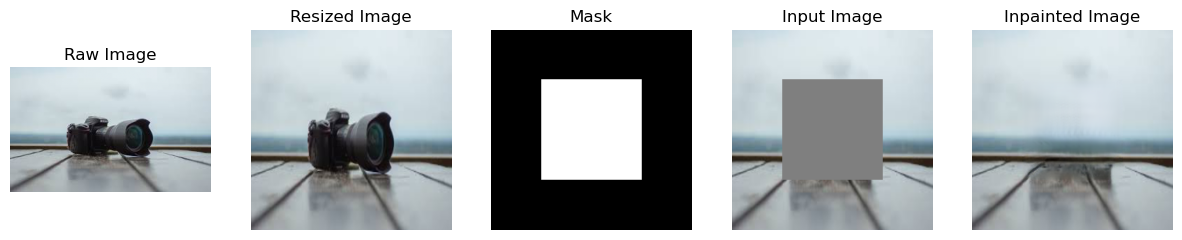

In [3]:
# Image shape: (256, 256, 3)
image_file = "input_imgs/camera.jpg"
mask_file = "generative_inpainting_pytorch/examples/center_mask_256.png"  # empty to use random mask
output_file = "output_imgs/output.png"
config_file = "generative_inpainting_pytorch/configs/config.yaml"

res_imgs = predict(
    image_file, mask_file, output_file=output_file, config_file=config_file
)

plot(res_imgs, ["Raw Image", "Resized Image", "Mask", "Input Image", "Inpainted Image"])

Random seed: 5285
Configuration: {'dataset_name': 'imagenet', 'data_with_subfolder': True, 'train_data_path': '/media/ouc/4T_A/datasets/ImageNet/ILSVRC2012_img_train/', 'val_data_path': None, 'resume': None, 'batch_size': 48, 'image_shape': [256, 256, 3], 'mask_shape': [128, 128], 'mask_batch_same': True, 'max_delta_shape': [32, 32], 'margin': [0, 0], 'discounted_mask': True, 'spatial_discounting_gamma': 0.9, 'random_crop': True, 'mask_type': 'hole', 'mosaic_unit_size': 12, 'expname': 'benchmark', 'cuda': True, 'gpu_ids': [0], 'num_workers': 4, 'lr': 0.0001, 'beta1': 0.5, 'beta2': 0.9, 'n_critic': 5, 'niter': 500000, 'print_iter': 100, 'viz_iter': 1000, 'viz_max_out': 16, 'snapshot_save_iter': 5000, 'coarse_l1_alpha': 1.2, 'l1_loss_alpha': 1.2, 'ae_loss_alpha': 1.2, 'global_wgan_loss_alpha': 1.0, 'gan_loss_alpha': 0.001, 'wgan_gp_lambda': 10, 'netG': {'input_dim': 3, 'ngf': 32}, 'netD': {'input_dim': 3, 'ndf': 64}}
generative_inpainting_pytorch\checkpoints\imagenet\hole_benchmark\gen_0

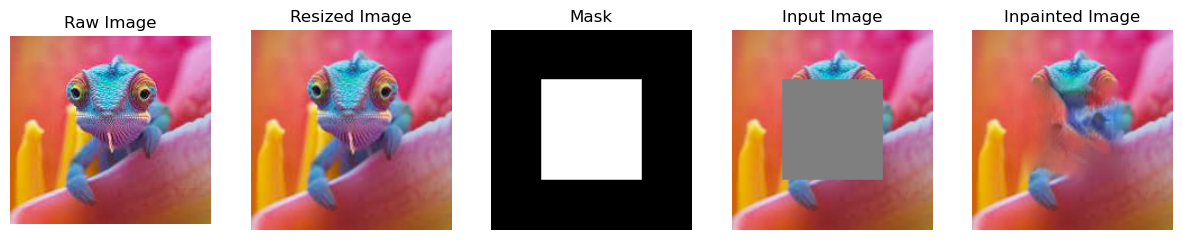

In [4]:
# Image shape: (256, 256, 3)
image_file = "input_imgs/chameleon.jpg"
mask_file = "generative_inpainting_pytorch/examples/center_mask_256.png"  # empty to use random mask
output_file = "output_imgs/output.png"
config_file = "generative_inpainting_pytorch/configs/config.yaml"

res_imgs = predict(
    image_file, mask_file, output_file=output_file, config_file=config_file
)

plot(res_imgs, ["Raw Image", "Resized Image", "Mask", "Input Image", "Inpainted Image"])